## Testing transforms.py

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# This file contains all the main external libs we'll use
from fastai.imports import *
from fastai.transforms import *
from fastai.plots import *
from fastai.dataset import *

In [2]:
bb =['195.927', '320.607', '954.697', '699.399']
f = 'img_02642.jpg'
PIL.Image.open("fastai/images/" + f).size

FileNotFoundError: [Errno 2] No such file or directory: 'fastai/images/img_02642.jpg'

In [3]:
PATH = "data/fish/"

In [4]:
fnames,corner_labels,_,_ = parse_csv_labels(f'{PATH}trn_bb_corners_labels', skip_header=False)

In [5]:
corner_labels["img_02642.jpg"]

['699.399', '954.697', '895.326', '1275.3']

In [6]:
def create_corner_rect(bb, color='red'):
    bb = np.array(bb, dtype=np.float32)
    return plt.Rectangle((bb[1], bb[0]), bb[3]-bb[1], bb[2]-bb[0], color=color, fill=False, lw=3)

def show_corner_bb(f='img_04908.jpg'):
    file_path = f'{PATH}images/{f}'
    bb = corner_labels[f]
    plots_from_files([file_path])
    plt.gca().add_patch(create_corner_rect(bb))

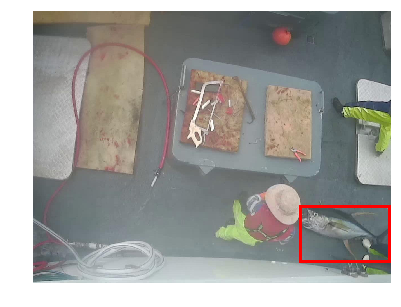

In [7]:
show_corner_bb(f = 'img_02642.jpg')

In [8]:
def get_x(f):
        file_path = f'{PATH}/images/{f}'
        im = PIL.Image.open(file_path).convert('RGB')
        return np.array(im, dtype=np.float32)/255.

In [9]:
f = 'img_02642.jpg'
x = get_x(f)
y = np.array(corner_labels[f], dtype=np.float32)
y

array([  699.399,   954.697,   895.326,  1275.3  ], dtype=float32)

In [10]:
x.shape

(974, 1280, 3)

In [11]:
corner_labels[f]

['699.399', '954.697', '895.326', '1275.3']

In [12]:
def create_rect(bb, color='red'):
    return plt.Rectangle((bb[1], bb[0]), bb[3]-bb[1], bb[2]-bb[0], color=color, fill=False, lw=3)

def plotXY(x,y):
    plots([x])
    plt.gca().add_patch(create_rect(y))

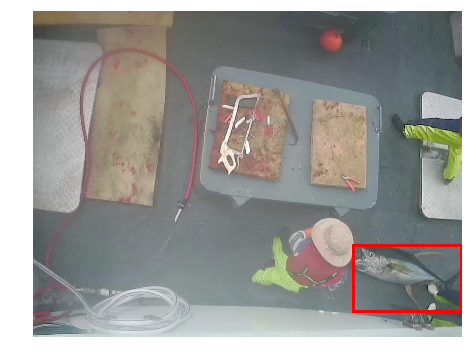

In [13]:
plotXY(x,y)

In [96]:
import enum

class TfmType(enum.Enum):
    NO = 1
    PIXEL = 2
    COORD = 3

class Transform():
    def __init__(self, tfm_y=TfmType.NO): self.tfm_y=tfm_y
    def __call__(self, x, y):
        self.set_state()
        x,y = ((self.transform(x),y) if self.tfm_y==TfmType.NO
                else self.transform(x,y) if self.tfm_y==TfmType.PIXEL
                else self.transform_coord(x,y))
        return x,y

    def transform_coord(self, x, y): return self.transform(x),y
    
    def transform(self, x, y=None):
        x = self.do_transform(x)
        return (x, self.do_transform(y)) if y is not None else x

    def do_transform(self, x): raise NotImplementedError

## Random Dihedral

In [97]:
def to_bb(YY):
    ((r1,r2),(c1,c2)) = np.nonzero(YY)
    top_row = min(r1,r2)
    left_col = min(c1,c2)
    h = np.abs(r1-r2)
    w = np.abs(c1-c2)
    return np.array([top_row, left_col, top_row + h, left_col + w])

def coords2px(y):
    rows = np.rint([y[0], y[2]]).astype(int)
    cols = np.rint([y[1], y[3]]).astype(int)
    Y = np.zeros((x.shape[0], x.shape[1]))
    Y[rows, cols] = 1
    return Y

In [98]:
class CoordTransform(Transform):
    def transform_coord(self, x, y):
        y = coords2px(y)
        x,y = self.transform(x,y)
        y = to_bb(y)
        return x, y

In [99]:
class RandomDihedralXY(CoordTransform):
    def set_state(self):
        self.rot_times = random.randint(0,3)
        self.do_flip = random.random()<0.5

    def do_transform(self, x):
        x = np.rot90(x, self.rot_times)
        return np.fliplr(x).copy() if self.do_flip else x

In [100]:
xx, y = RandomDihedralXY(TfmType.NO)(x, y)

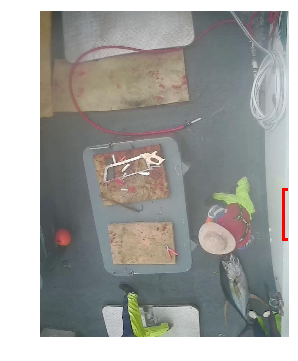

In [101]:
plotXY(xx,y)

In [102]:
xx, yy = RandomDihedralXY(TfmType.COORD)(x, y)

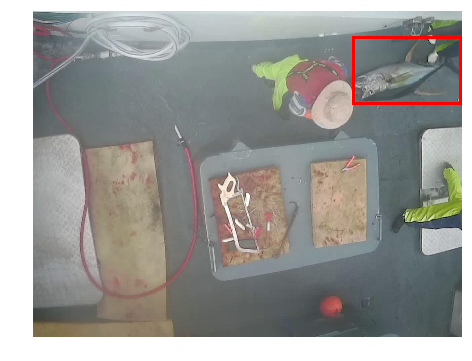

In [103]:
plotXY(xx,yy)

In [104]:
xx, yy = RandomDihedralXY(TfmType.PIXEL)(x, x)

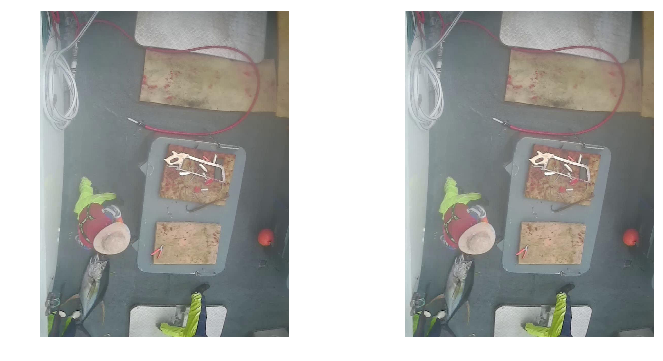

In [105]:
plots([xx,yy])